## DAtaset

Veamos cómo construir un dataset de lo que ya tenemos

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

Primero, veamos qué usuarios etiquetaron más de 4 artículos...

In [2]:
from django.db.models import Count, Case, When, Value

annotated_articles = Article.objects.exclude(batch__name="training").annotate(
    num_labels=Count('labels'),
    effective_labels=Count(
        Case(When(labels__is_interesting=True, then=Value(1)))
    )
)


really_annotated_articles = annotated_articles.filter(effective_labels=3).count()

skipped = 0

for art in annotated_articles:
    if art.num_labels > art.effective_labels:
        skipped +=1


print(f"Artículos totales: {Article.objects.count()}")
print(f"Artículos con 3 anotaciones: {really_annotated_articles}")
print(f"Artículos con alguna anotación: {annotated_articles.filter(num_labels__gte=1).count()}")
print(f"Artículos que no pasaron a tercera anotación: {skipped}")

Artículos totales: 1108
Artículos con 3 anotaciones: 408
Artículos con alguna anotación: 719
Artículos que no pasaron a tercera anotación: 180


Vamos a crear primero tabla de comentarios

In [11]:
from datetime import datetime
from dataset import CommentSerializer, field_mapping


serializer = CommentSerializer()


def serialize_article(article):
    date = datetime.strftime(article.created_at, '%Y-%m-%dT%H:%M:%S.%fZ')
    ret = {
        "tweet_id": article.tweet_id,
        "title": article.title,
        "tweet_text": article.text,
        "body": article.body,
        "news": article.user,
        "date": date,
    }
    
    return ret


In [5]:

articles = []
comments = []


finished_articles = annotated_articles.filter(effective_labels=3).prefetch_related('comment_set', 'labels')
ignored_labels = 0

for article in tqdm(finished_articles):
    articles.append(serialize_article(article))
    for comment in article.comment_set.all():    
        new_comment = serializer.serialize(comment)
        comments.append(new_comment)

  0%|          | 0/408 [00:00<?, ?it/s]

In [6]:
serializer.ignored_labels

23

Text(0.5, 1.0, 'Histograma de cantidad de anotaciones discriminatorias por comentario')

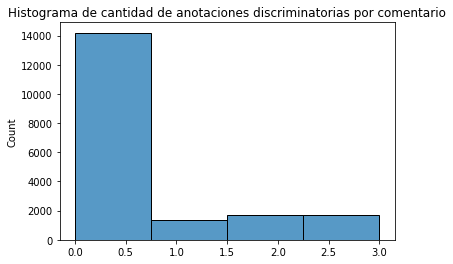

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(data=[len(c['HATE']) for c in comments], bins=4)

plt.title("Histograma de cantidad de anotaciones discriminatorias por comentario")

In [9]:
possibly_hateful = len([c for c in comments if len(c['HATE']) > 0])
hateful = len([c for c in comments if len(c['HATE']) >= 2])

full_agreement = len([c for c in comments if len(c['HATE']) == 3])

print(f"Comentarios totales                             : {len(comments)}")
print(f"Comentarios con >= 1 etiqueta de discriminación : {possibly_hateful}")
print(f"Comentarios con >= 2 etiqueta de discriminación : {hateful}")
print(f"Comentarios con >= 3 etiqueta de discriminación : {full_agreement}")
print(f"Ratio de comentarios odiosos sobre totales = {hateful / len(comments):.2f}")

Comentarios totales                             : 18934
Comentarios con >= 1 etiqueta de discriminación : 4741
Comentarios con >= 2 etiqueta de discriminación : 3365
Comentarios con >= 3 etiqueta de discriminación : 1678
Ratio de comentarios odiosos sobre totales = 0.18


In [12]:
def print_comment(comment):
    print(comment['text'])

    for name in field_mapping:
        if comment[name]:
            votes = len(comment[name])
            print(f"{name} --> {votes} votos ({' - '.join(comment[name])})")


for comment in comments:
    if len(comment["HATE"]) >= 2:
        print("="*80)
        print_comment(comment)
        


@usuario ¡Que cirujeada esta la supuesta enfermita!  Hipocritas.
HATE --> 3 votos (annotator_5 - annotator_2 - annotator_1)
WOMEN --> 2 votos (annotator_5 - annotator_1)
APPEARANCE --> 1 votos (annotator_2)
@usuario Tendrían q ir directamente a la cárcel de Ezeiza. Por Truchas, chorras y fieras! 🤮
HATE --> 3 votos (annotator_5 - annotator_2 - annotator_1)
CALLS --> 1 votos (annotator_2)
WOMEN --> 1 votos (annotator_5)
POLITICS --> 1 votos (annotator_2)
APPEARANCE --> 1 votos (annotator_1)
@usuario Jajajaaj está cruela tuneada que se ocupe de su reino feudal mejor
HATE --> 2 votos (annotator_5 - annotator_2)
WOMEN --> 1 votos (annotator_5)
APPEARANCE --> 2 votos (annotator_5 - annotator_2)
@usuario Pero my darling #Magario como vas a hacer para mantener ese color rubio groncho natural que usas en tu pelo? 🙄
HATE --> 3 votos (annotator_5 - annotator_2 - annotator_1)
WOMEN --> 3 votos (annotator_5 - annotator_2 - annotator_1)
APPEARANCE --> 2 votos (annotator_5 - annotator_1)
@usuario La 